In [3]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

2. 읍면동 경계 데이터 불러오기

In [13]:
# 1. 읍면동 경계(Polygon) 데이터 불러오기

gdf = gpd.read_file(
    './LSMD_ADM_SECT_UMD_경기/LSMD_ADM_SECT_UMD_41_202506.shp',
    encoding='cp949'  # 또는 encoding='euc-kr'
)
print(gdf[['EMD_CD', 'EMD_NM']].head())

     EMD_CD EMD_NM
0  41115131    장안동
1  41115130    신풍동
2  41115129    북수동
3  41115128    매향동
4  41115127    남수동


In [14]:
print(gdf.columns)

Index(['EMD_CD', 'COL_ADM_SE', 'EMD_NM', 'SGG_OID', 'geometry'], dtype='object')


In [15]:
# 포천시 읍면동만 추출
pocheon_gdf = gdf[gdf['EMD_CD'].str.startswith('41650')].copy()
print(pocheon_gdf[['EMD_CD', 'EMD_NM']])

       EMD_CD EMD_NM
668  41650390    영북면
669  41650350    창수면
670  41650370    일동면
671  41650310    군내면
672  41650105    설운동
673  41650320    내촌면
674  41650360    영중면
675  41650106    동교동
676  41650340    신북면
677  41650410    화현면
678  41650102    어룡동
679  41650101    신읍동
680  41650250    소흘읍
681  41650330    가산면
682  41650104    선단동
683  41650103    자작동
684  41650380    이동면
685  41650400    관인면


In [16]:
print(pocheon_gdf['EMD_NM'].unique())

['영북면' '창수면' '일동면' '군내면' '설운동' '내촌면' '영중면' '동교동' '신북면' '화현면' '어룡동' '신읍동'
 '소흘읍' '가산면' '선단동' '자작동' '이동면' '관인면']


3. 행정동코드와 merge (속성 확장)

In [ ]:
# 3. 행정동코드.csv 불러오기
code_df = pd.read_csv('./데이터_전처리후/7_행정동코드/행정동코드.csv', dtype=str)
print(code_df.head())
# ADMINIST_DONG_CD : 행정동 코드 (읍·면·동 단위의 고유 식별자, 10자리)
# SIDO_NM : 시·도명 (광역자치단체 이름)
# SIGNGU_NM : 시·군·구명 (기초자치단체 이름)
# EMD_NM : 읍·면·동명 (행정동 이름)
# LEGALDONG_CD : 법정동 코드 (법정동 단위의 고유 식별자, 10자리)
# DONG_LI_NM : 동/리 이름 (법정동/법정리 이름, 더 세분화된 동네 이름)
# CREAT_DE : 생성일 (해당 행정동 코드가 생성된 날짜, YYYYMMDD)

  ADMINIST_DONG_CD SIDO_NM SIGNGU_NM EMD_NM LEGALDONG_CD DONG_LI_NM  CREAT_DE
0       4100000000     경기도       NaN    NaN   4100000000        경기도  19880423
1       4111000000     경기도       수원시    NaN   4111000000        수원시  19880423
2       4111100000     경기도   수원시 장안구    NaN   4111100000     수원시장안구  19880701
3       4111156000     경기도   수원시 장안구    파장동   4111112900        파장동  20031124
4       4111156000     경기도   수원시 장안구    파장동   4111113100        이목동  20031124


In [25]:
pocheon_gdf['EMD_CD'] = pocheon_gdf['EMD_CD'].astype(str)
code_df['ADMINIST_DONG_CD'] = code_df['ADMINIST_DONG_CD'].astype(str)

In [ ]:
# 4. 읍면동 코드 기준 merge
merged = pocheon_gdf.merge(code_df, left_on='EMD_CD', right_on='ADMINIST_DONG_CD', how='left')
print(merged.columns)
# EMD_CD : 공간데이터의 읍면동 코드
# EMD_NM_x : 공간데이터의 읍면동명
# ADMINIST_DONG_CD : 행정동코드.csv의 읍면동 코드
# EMD_NM_y : 행정동코드.csv의 읍면동명

Index(['EMD_CD', 'COL_ADM_SE', 'EMD_NM_x', 'SGG_OID', 'geometry',
       'ADMINIST_DONG_CD', 'SIDO_NM', 'SIGNGU_NM', 'EMD_NM_y', 'LEGALDONG_CD',
       'DONG_LI_NM', 'CREAT_DE'],
      dtype='object')


In [29]:
print(merged[['EMD_CD', 'EMD_NM_x', 'ADMINIST_DONG_CD', 'EMD_NM_y']].head())

     EMD_CD EMD_NM_x ADMINIST_DONG_CD EMD_NM_y
0  41650390      영북면              NaN      NaN
1  41650350      창수면              NaN      NaN
2  41650370      일동면              NaN      NaN
3  41650310      군내면              NaN      NaN
4  41650105      설운동              NaN      NaN


4. 중심좌표(centroid), 면적 등 추출


In [31]:
# 5. 중심좌표, 면적 컬럼 추가
merged['centroid'] = merged.geometry.centroid
merged['lon'] = merged.centroid.x
merged['lat'] = merged.centroid.y
merged['area'] = merged.geometry.area
print(merged[['EMD_NM_x', 'lat', 'lon', 'area']].head())

  EMD_NM_x            lat            lon          area
0      영북면  608229.189015  224994.785459  8.171090e+07
1      창수면  602558.427863  215537.645363  7.153179e+07
2      일동면  596086.231286  228492.061488  8.320359e+07
3      군내면  586409.292293  220194.869780  3.616228e+07
4      설운동  584389.252146  212500.780361  5.297205e+06


5. 인접 읍면동 그래프 생성 (경계 기반)


In [34]:
# 6. 인접(경계가 맞닿은) 읍면동 찾기
edges = set()
for idx, row in merged.iterrows():
    neighbors = merged[merged.touches(row['geometry'])]
    for nidx, nrow in neighbors.iterrows():
        edge = tuple(sorted([row['EMD_CD'], nrow['EMD_CD']]))
        edges.add(edge)

# 7. NetworkX 그래프 생성
G = nx.Graph()
for idx, row in merged.iterrows():
    G.add_node(row['EMD_CD'], name=row['EMD_NM_x'], pos=(row['lon'], row['lat']))
for edge in edges:
    G.add_edge(*edge)

6. 시각화 (경계 + 인접 그래프)


In [39]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (예: 맑은 고딕, AppleGothic 등)
plt.rcParams['font.family'] = 'AppleGothic'  # Mac
# plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 깨짐 방지

In [42]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

coords = merged[['lon', 'lat']].values
K = 4  # 기존보다 크게
nbrs = NearestNeighbors(n_neighbors=K+1, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)

edges = set()
for i, neighbors in enumerate(indices):
    for j in neighbors[1:]:  # 자기 자신 제외
        edge = tuple(sorted([i, j]))
        edges.add(edge)

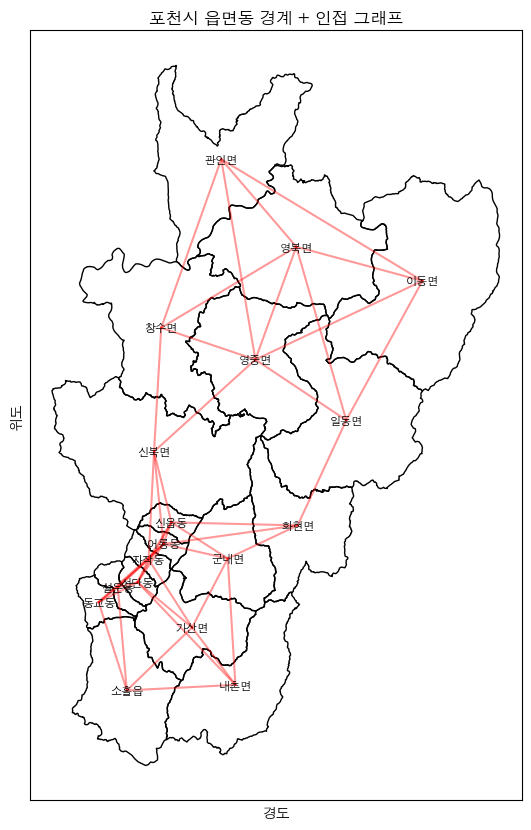

In [45]:
# 8. 지도 위에 경계와 인접 그래프 함께 시각화
fig, ax = plt.subplots(figsize=(10, 10))
merged.plot(ax=ax, edgecolor='black', facecolor='none')

# 중심좌표에 노드명 표시
for idx, row in merged.iterrows():
    plt.text(row['lon'], row['lat'], row['EMD_NM_x'], fontsize=8, ha='center', va='center')

# 인접 엣지 그리기
for edge in edges:
    i, j = edge
    x = [merged.iloc[i]['lon'], merged.iloc[j]['lon']]
    y = [merged.iloc[i]['lat'], merged.iloc[j]['lat']]
    plt.plot(x, y, color='red', alpha=0.4)

ax.set_xticks([])
ax.set_yticks([])
plt.title("포천시 읍면동 경계 + 인접 그래프")
plt.xlabel("경도")
plt.ylabel("위도")
plt.grid(False)
#ax.axis('off')
plt.show()

7. 요약

포천시 읍면동 경계, 중심좌표, 면적, 인접관계를 모두 추출/시각화할 수 있습니다.

이 그래프를 딥러닝(GNN, ST-GCN 등) 입력으로 바로 활용할 수 있습니다.